# Notebook for more Features of the Data

In [1]:
# Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# to enable local imports
module_path = os.path.abspath('code')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning_data_generation import loadOnlineEEGdata, loadPickeldData, loadPickeldDataset

D:\Masterthesis\thesis_eeg\code


Using TensorFlow backend.


### Load one epoch Series

In [2]:
DATA_DIR = "../EEG_Data/eeg_data_online/1"
LABEL = "normal"
epochSeries, frequencyFeatureDf = loadPickeldData(DATA_DIR, label=LABEL)
print("Loaded '{}' epoch Series and freqDf from {} ".format(LABEL.upper(), DATA_DIR))

Loaded 'NORMAL' epoch Series and freqDf from ../EEG_Data/eeg_data_online/1 


In [18]:
eegData, freqData = loadOnlineEEGdata(splitData=False)
eegX, eegy = eegData
freqX, freqy = freqData

Loading Online EEG Data from D:/Masterthesis/EEG_Data/eeg_data_online ...
Data does not get splitted into train and test!
EEG Data Shape:
(7178, 512, 40) (7178,)
Freq Data Shape:
(1440, 1, 1200) (1440,)


# Time Domain Features
- (Raw) Normal Signal
- Maximum
- Minimum
- Standard Deviation

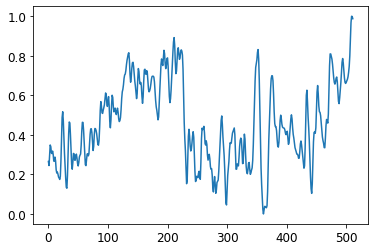

In [22]:
epochSeries[10].channel_7.plot()

In [25]:
epochSeries[10].channel_7.std()

0.2080001750890229

# Entropy Features
 - Approximate Entropy (AE)
 - Sample Entropy (SamE)
 - Spectral Entropy (SpeE)
 - Permutation Entropy (PE)
 - Singular Value Decomposition Entropy (SvdE)
 
 Used package: https://raphaelvallat.com/entropy/build/html/index.html

### Approximate Entropy

In [62]:
import entropy
from typing import List

def createEmptyNumpyArray(d1, d2=None, d3=None):
    ''' Function to create an empty numpy Array, with the given dimesion'''
    if d2 is None and d3 is None:
        numpyArray = np.zeros((d1))
    
    elif d2 is not None and d3 is None:
        numpyArray = np.zeros((d1, d2))
    
    elif d3 is not None and d3 is not None:
        numpyArray = np.zeros((d1, d2, d3))
    
    print("Created Numpy Array - Shape: {}".format(numpyArray.shape))
    return numpyArray

def addFeatureToList(featureList, featureListIndex, newFeatureName):
    ''' Add a feature to a list, with a given index'''
    if newFeatureName not in featureList:
        featureList[featureListIndex] = newFeatureName
    return featureList

def createEntropyFeatureArray(epochSeries : pd.Series, samplingFreq : int) -> (np.ndarray, List[str]):
    ''' Creates 3d Numpy with a entropy features - also returns the feature names'''
    # Create np array, where the data will be stored
    d1 = len(epochSeries) # First Dimesion
    d2 = 1 # only one sample in that epoch
    
    channels = len(epochSeries[0].columns)
    d3 = channels * 5 # second dimension - 5 because we calculate five different entropies for each channel
    
    entropyFeatureArrayX = createEmptyNumpyArray(d1, d2, d3)
    
    # Create a list where all feature names are stored
    entropyFeatureList = [None] * d3
    
    stepSize = 5 # step is 5 because we calculate 5 different entropies
    for i in range (0, len(epochSeries)):
        
        # We start the the stepz size and loop through the columns, but we have to multiply by the stepzsize and add once the step size (because we don't start at 0)
        for j in range(stepSize, (len(epochSeries[i].columns)*stepSize)+stepSize, stepSize): 
            
            # j_epoch is the normalized index for the epoch series (like the step size would be 1)
            j_epoch = j/stepSize - 1
            
            # get the column name
            col = epochSeries[i].columns[j_epoch]
            
            # The values of the epoch of the current column
            colEpochList = epochSeries[i][col].tolist()
            
            ######################################
            # calculate Approximate Entropy
            # ------------------------------------
            val = entropy.app_entropy(colEpochList, order=2)
            # if the value is NaN, just set it to 0
            if np.isnan(val):
                val = 0
            entropyFeatureArrayX[i][0][j-1] = val
            
            # add approximate entropy feature to the list
            entropyFeatureList = addFeatureToList(featureList = entropyFeatureList,
                                                  featureListIndex = j-1,
                                                  newFeatureName = "{col}_approximate_entropy".format(col=col))
            
            ######################################
            # calculate Sample Entropy
            # ------------------------------------
            val = entropy.sample_entropy(colEpochList, order=2)
            # if the value is NaN, just set it to 0
            if np.isnan(val):
                val = 0
            entropyFeatureArrayX[i][0][j-2] = val
            
            entropyFeatureList = addFeatureToList(featureList = entropyFeatureList,
                                                  featureListIndex = j-2,
                                                  newFeatureName = "{col}_sample_entropy".format(col=col))
            
            ######################################
            # calculate Spectral Entropy
            # ------------------------------------
            val = entropy.spectral_entropy(colEpochList, sf=samplingFreq ,method='fft', normalize=True)
            # if the value is NaN, just set it to 0
            if np.isnan(val):
                val = 0
            entropyFeatureArrayX[i][0][j-3] = val
            
            entropyFeatureList = addFeatureToList(featureList = entropyFeatureList,
                                                  featureListIndex = j-3,
                                                  newFeatureName = "{col}_spectral_entropy".format(col=col))
            
            ######################################
            # calculate Permutation Entropy
            # ------------------------------------
            val = entropy.perm_entropy(colEpochList, order=3, normalize=True, delay=1)
            # if the value is NaN, just set it to 0
            if np.isnan(val):
                val = 0
            entropyFeatureArrayX[i][0][j-4] = val
            
            entropyFeatureList = addFeatureToList(featureList = entropyFeatureList,
                                                  featureListIndex = j-4,
                                                  newFeatureName = "{col}_permutation_entropy".format(col=col))
            
            ######################################
            # calculate Singular Value Decomposition entropy.
            # ------------------------------------
            val = entropy.svd_entropy(colEpochList, order=3, normalize=True, delay=1)
            # if the value is NaN, just set it to 0
            if np.isnan(val):
                val = 0
            entropyFeatureArrayX[i][0][j-5] = val
            
            entropyFeatureList = addFeatureToList(featureList = entropyFeatureList,
                                                  featureListIndex = j-5,
                                                  newFeatureName = "{col}_svd_entropy".format(col=col))
            
            #break
        #break
    
    return entropyFeatureArrayX, entropyFeatureList

In [63]:
entropyX, entropyX_featureList = createEntropyFeatureArray(epochSeries, 256)

Created Numpy Array - Shape: (299, 1, 200)


d:\masterthesis\entropy\entropy\entropy.py:179: RuntimeWarning: invalid value encountered in true_divide
  psd_norm = np.divide(psd, psd.sum())
d:\masterthesis\entropy\entropy\entropy.py:252: RuntimeWarning: invalid value encountered in true_divide
  W /= sum(W)
d:\masterthesis\entropy\entropy\entropy.py:179: RuntimeWarning: invalid value encountered in true_divide
  psd_norm = np.divide(psd, psd.sum())
d:\masterthesis\entropy\entropy\entropy.py:252: RuntimeWarning: invalid value encountered in true_divide
  W /= sum(W)
d:\masterthesis\entropy\entropy\entropy.py:179: RuntimeWarning: invalid value encountered in true_divide
  psd_norm = np.divide(psd, psd.sum())
d:\masterthesis\entropy\entropy\entropy.py:252: RuntimeWarning: invalid value encountered in true_divide
  W /= sum(W)
d:\masterthesis\entropy\entropy\entropy.py:179: RuntimeWarning: invalid value encountered in true_divide
  psd_norm = np.divide(psd, psd.sum())
d:\masterthesis\entropy\entropy\entropy.py:252: RuntimeWarning: inv

(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14865c1e688>)

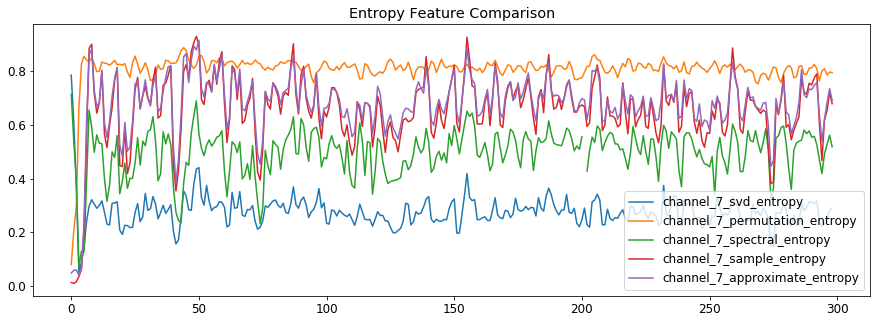

In [86]:
def createEntropyFeaturePlot(entropyArray : np.ndarray, featureIndex, featureList):
    fig, ax = plt.subplots(figsize=(15,5))
    
    if type(featureIndex) is list:
        ax.set_title('Entropy Feature Comparison')
        for index in featureIndex:
            ax.plot(entropyArray[:,:,index], label = featureList[index])
        plt.legend(loc="best")
    else:
        ax.set_title('Entropy Feature {}'.format(featureList[featureIndex]))
        ax.plot(entropyArray[:,:,featureIndex])
        
    return fig, ax

createEntropyFeaturePlot(entropyArray=entropyX, featureIndex=[30,31,32,33,34], featureList=entropyX_featureList)

In [76]:
#entropyX[:,:,5]

list

# Wavelet Decompostion

# Freqeucny Feautures
- The ones we already have
- Ratios between different frequency bands (Using EEG spectral components to assess algorithms for detecting fatigue)
    - (Theta + Alpha) / Beta
    - Alpha / Beta
    - (Theta + Alpha) / (Alpha + Beta)
    - Theta / Beta